In [1]:
import pandas as pd
import re, time, os
import json
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
# =============================================
# ============ | CREATING DIRs | ==============
# =============================================

directories = ["model", "checkpoints"]

for dir in directories:
    if not os.path.isdir(dir):
        os.mkdir(dir)

In [4]:
# =================================================
# ============ | PROGRAM ARGUMENTS | ==============
# =================================================

WRITE_VOCAB = True                   # Required for prediction
OVERWRITE_MODEL = True               # Required for prediction
SAVE_CHECKPOINTS = False
LOAD_CHECKPOINT_METRICS = True
WRITE_CHECKPOINT_METRICS = False

if LOAD_CHECKPOINT_METRICS and not SAVE_CHECKPOINTS:
    print("WARNING: Checkpoints needs to be written for metrics (ignore if checkpoints have already been generated).")

if LOAD_CHECKPOINT_METRICS and WRITE_CHECKPOINT_METRICS:
    print("WARNING: Load and Write checkpoint metrics are both set to True. Write will be defaulted to False.")

# Part 1: Data Processing

In [5]:
# =============================================
# ============= | LOAD & CLEAN | ==============
# =============================================
data = pd.read_csv("AI_Human.csv")
data = data.rename(columns={'generated': 'label'})
# data = data.sample(frac=0.1, random_state=42) 
data['label'] = data['label'].astype(int)

def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d', '', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

data['text'] = data['text'].apply(preprocess_text)

In [6]:
# =======================================================
# ============= | TRAINING/TESTING SPLIT | ==============
# =======================================================
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

In [7]:
# ==============================================
# ============= | DATASET CLASS | ==============
# ==============================================
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        tokens = self.tokenizer(text)
        input_ids = tokens + [0] * (self.max_len - len(tokens))  # Pad to max_len
        input_ids = input_ids[:self.max_len]  # Truncate if longer than max_len
        return torch.tensor(input_ids, dtype=torch.long), torch.tensor(label, dtype=torch.long)

In [8]:
# ==================================================
# ============= | TEXT TOKENIZATION | ==============
# ==================================================
vocab = set(' '.join(data['text']).split())
vocab = {word: idx + 1 for idx, word in enumerate(vocab)}
vocab['<UNK>'] = 0


if WRITE_VOCAB:
    vocab_tokenizer = "./model/vocab.json"
    with open(vocab_tokenizer, "w") as wf:
        json.dump(vocab, wf)

max_len = 512
def tokenizer(text):
    return [vocab.get(word, vocab['<UNK>']) for word in text.split()]

train_dataset = TextDataset(train_data['text'].tolist(), train_data['label'].tolist(), tokenizer, max_len)
test_dataset = TextDataset(test_data['text'].tolist(), test_data['label'].tolist(), tokenizer, max_len)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Part 2: Building LSTM model

In [9]:
# =================================================
# ============= | LSTM MODEL CLASS | ==============
# =================================================
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout=0.5):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        output = self.fc(lstm_out[:, -1, :])                                                                                            
        return output


In [10]:
# ==================================================================
# ============= | MODEL TRAINING/TESTING PARAMETERS | ==============
# ==================================================================

# Checkpoint threshold for the model, optimizer, and step
# Steps under 1000 will render this program impossible to run on my local machine
# due to the insanely large aggregated checkpoint files and the incredibly long runtime
save_steps = 1000
output_dir = "./checkpoints"

# Model
vocab_size = len(vocab)
embedding_dim = 100
hidden_dim = 256
output_dim = 2
n_layers = 2
num_epochs = 3
learning_rate = 1e-4

model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)



In [11]:
# Training for just one step
def train_step(model, batch, criterion, optimizer):
    model.train()
    inputs, labels = batch
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    return loss.item()


def evaluate(model, dataloader, type: str):
    model.eval()
    all_preds = []
    all_labels = []
    batch_times = [] # used for est time calc

    with torch.no_grad():
        total_batches = len(dataloader)
        for batch_idx, batch in enumerate(dataloader):
            batch_start_time = time.time()

            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)

            # Needs to be in the cpu as opposed to the gpu apparantly
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            batch_time = time.time() - batch_start_time
            batch_times.append(batch_time)

            avg_batch_time = sum(batch_times) / len(batch_times)
            batches_remaining = total_batches - (batch_idx + 1)
            time_left = avg_batch_time * batches_remaining

            if batch_idx % 100 == 0 and batch_idx != 0:
                print(f"[{type}] Evaluating Batch [{batch_idx + 1}/{total_batches}] - Est. Time Left: {time_left:.2f} seconds", end="\r")
            if batch_idx % 10000 == 0 and batch_idx != 0:
                print("")
        print("")
        
    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary', zero_division=0)
    return {'accuracy': acc, 'precision': precision, 'recall': recall, 'f1': f1}

# Saves model checkpoint to file (crazy size when aggragated).
def save_checkpoint(model, optimizer, step, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    checkpoint_path = os.path.join(output_dir, f"checkpoint-{step}.pth")
    torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'step': step
    }, checkpoint_path)

# Used for post-training evalution for the graphs
def evaluate_checkpoint(checkpoint_path, train_dataloader, test_dataloader, device):
    checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=True) # doesn't load if waights_only=False
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()

    # Evaluate on training and testing datasets
    train_metrics = evaluate(model, train_dataloader, "Train")
    test_metrics = evaluate(model, test_dataloader, "Test")

    return train_metrics, test_metrics

# Part 3: Training and Evaluating the Model

In [ ]:
# =========================================
# ============= | TRAINING | ==============
# =========================================

global_step = 0
total_steps = num_epochs * len(train_loader)
start_time = time.time()

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    for batch_idx, batch in enumerate(train_loader):
        batch_start_time = time.time()
        
        loss = train_step(model, batch, criterion, optimizer)
        global_step += 1

        elapsed_time = time.time() - start_time
        steps_remaining = total_steps - global_step
        avg_step_time = elapsed_time / global_step
        time_left = steps_remaining * avg_step_time

         
        if global_step % save_steps == 0:
            # Save checkpoint on threshold
            if SAVE_CHECKPOINTS:
                save_checkpoint(model, optimizer, global_step, output_dir)
            print(f"Epoch [{epoch + 1}/{num_epochs}] - [{global_step}/{total_steps}] Loss: {loss:.4f}, Est. Time Left: {time_left:.2f} seconds")


    # Evaluate metrics at the end of the epoch
    train_metrics = evaluate(model, train_loader, type="Training")
    test_metrics = evaluate(model, test_loader, type="Testing")

    epoch_time = time.time() - epoch_start_time
    print(f"\nEpoch {epoch + 1} completed in {epoch_time:.2f} seconds.")
    print(f"  Train Metrics: {train_metrics}")
    print(f"  Test Metrics: {test_metrics}\n")

Epoch [1/3] - [1000/146172] Loss: 0.7108, Est. Time Left: 5217.27 seconds
Epoch [1/3] - [2000/146172] Loss: 0.6625, Est. Time Left: 5178.97 seconds
Epoch [1/3] - [3000/146172] Loss: 0.6308, Est. Time Left: 5134.49 seconds
Epoch [1/3] - [4000/146172] Loss: 0.6516, Est. Time Left: 5095.20 seconds
Epoch [1/3] - [5000/146172] Loss: 0.5722, Est. Time Left: 5058.95 seconds
Epoch [1/3] - [6000/146172] Loss: 0.2136, Est. Time Left: 5022.08 seconds
Epoch [1/3] - [7000/146172] Loss: 0.6155, Est. Time Left: 4987.44 seconds
Epoch [1/3] - [8000/146172] Loss: 0.1059, Est. Time Left: 4950.39 seconds
Epoch [1/3] - [9000/146172] Loss: 0.3154, Est. Time Left: 4913.76 seconds
Epoch [1/3] - [10000/146172] Loss: 0.0072, Est. Time Left: 4876.91 seconds
Epoch [1/3] - [11000/146172] Loss: 0.5737, Est. Time Left: 4839.79 seconds
Epoch [1/3] - [12000/146172] Loss: 0.0544, Est. Time Left: 4803.20 seconds
Epoch [1/3] - [13000/146172] Loss: 0.0097, Est. Time Left: 4766.79 seconds
Epoch [1/3] - [14000/146172] Loss:

In [13]:
# ======================================================
# ================== | SAVE MODEL | ====================
# ======================================================

pickle_model_path = f"./model/lstm_model.pkl"

if OVERWRITE_MODEL:
    with open(pickle_model_path, 'wb') as wf:
        pickle.dump(model, wf)
    print(f"Model saved as a pickle file to {pickle_model_path}")

Model saved as a pickle file to ./model/lstm_model.pkl


## Checkpoint Evaluation

In [22]:
# ======================================================
# ============= | CHECKPOINT EVALUATION | ==============
# ======================================================
checkpoint_metrics = {
    'steps': [],
    'train_accuracy': [],
    'test_accuracy': [],
    'train_f1': [],
    'test_f1': [],
    'train_precision': [],
    'test_precision': [],
    'train_recall': [],
    'test_recall': []
}

if LOAD_CHECKPOINT_METRICS:
    checkpoints_metrics_file = "./model/checkpoint_metrics.json"

    if os.path.isfile(checkpoints_metrics_file):
        with open(checkpoints_metrics_file, "r") as rf:
            checkpoint_metrics = json.load(rf)
            print(f"Previously generated checkpoint metrics are loaded (from {checkpoints_metrics_file}).")
    else:
        print("Checkpoint metrics cannot be found.")

else:
    for step in range(save_steps, global_step + 1, save_steps):
        print(f"\nEvaluating checkpoint {step}/{global_step}...")
        
        checkpoint_path = os.path.join(output_dir, f"checkpoint-{step}.pth")
        train_metrics, test_metrics = evaluate_checkpoint(checkpoint_path, train_loader, test_loader, device)

        checkpoint_metrics['steps'].append(step)
        checkpoint_metrics['train_accuracy'].append(train_metrics['accuracy'])
        checkpoint_metrics['test_accuracy'].append(test_metrics['accuracy'])
        checkpoint_metrics['train_f1'].append(train_metrics['f1'])
        checkpoint_metrics['test_f1'].append(test_metrics['f1'])
        checkpoint_metrics['train_precision'].append(train_metrics['precision'])
        checkpoint_metrics['test_precision'].append(test_metrics['precision'])
        checkpoint_metrics['train_recall'].append(train_metrics['recall'])
        checkpoint_metrics['test_recall'].append(test_metrics['recall'])



Previously generated checkpoint metrics are loaded (from ./model/checkpoint_metrics.json).


In [23]:
# ======================================================
# ============ | SAVE CHECKPOINT METRICS | =============
# ======================================================

# force write to false if data is loaded
if LOAD_CHECKPOINT_METRICS == True:
    WRITE_CHECKPOINT_METRICS = False 

if WRITE_CHECKPOINT_METRICS:
    checkpoints_metrics_file = "./model/checkpoint_metrics.json"
    
    with open(checkpoints_metrics_file, "w") as wf:
        json.dump(checkpoint_metrics, wf)
    print("Checkpoint metrics JSON recorded.")

Total Accuracy Count: 73


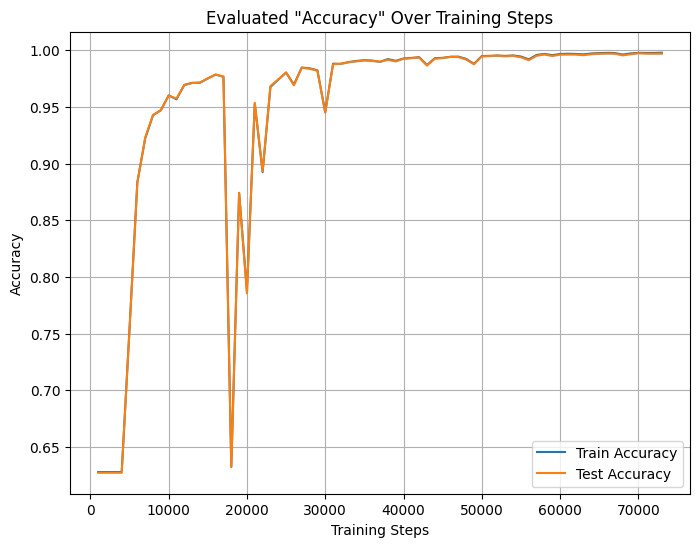

Total F1 Count: 73


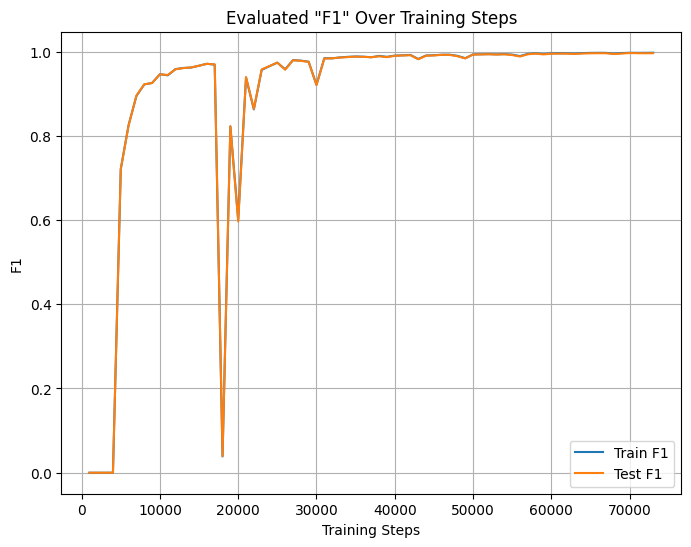

Total Precision Count: 73


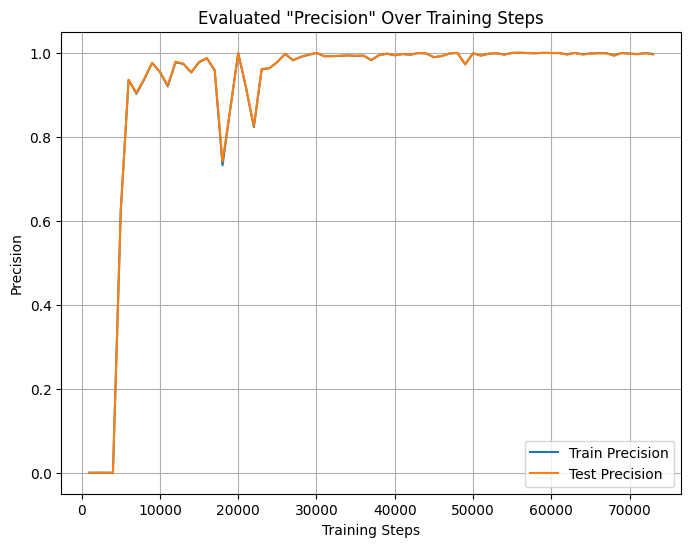

Total Recall Count: 73


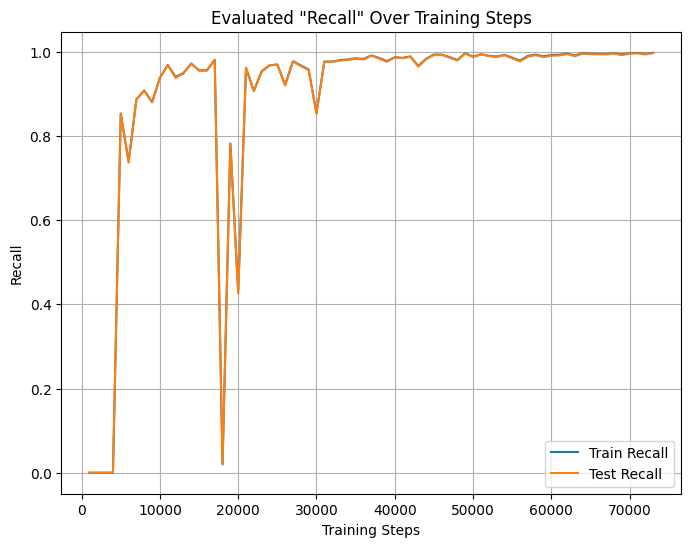

In [24]:
# ======================================
# ============= | GRAPH | ==============
# ======================================
metrics = ['accuracy', 'f1', 'precision', 'recall']

for metric in metrics:
    print(f"Total {metric.capitalize()} Count: {len(checkpoint_metrics[f'train_{metric}'])}")
    
    plt.figure(figsize=(8, 6))
    plt.plot(checkpoint_metrics['steps'], checkpoint_metrics[f'train_{metric}'], label=f"Train {metric.capitalize()}")
    plt.plot(checkpoint_metrics['steps'], checkpoint_metrics[f'test_{metric}'], label=f"Test {metric.capitalize()}")
    plt.xlabel("Training Steps")
    plt.ylabel(metric.capitalize())
    plt.title(f'Evaluated "{metric.capitalize()}" Over Training Steps')
    plt.legend()
    plt.grid()
    plt.show()
    